In [2]:
import numpy as np
import scipy as sc
import roboticstoolbox as rtb
import spatialmath as sm
import spatialmath.base.symbolic as sym
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [ ]:
class irb140_clase(rtb.DHRobot):
    def __init__(self):
        #defino al robot y sus parámetros DH
        super().__init__([
            rtb.RevoluteDH(alpha=-np.pi/2,a=0.07, qlim=[-np.pi,np.pi]),
            rtb.RevoluteDH(a=0.36,offset=-np.pi/2, qlim=[-np.pi,np.pi]),
            rtb.RevoluteDH(alpha=np.pi/2,offset=np.pi, qlim=[-np.pi,np.pi]),
            rtb.RevoluteDH(d=0.38, alpha=-np.pi/2, qlim=[-np.pi,np.pi]),
            rtb.RevoluteDH(alpha=np.pi/2, qlim=[-np.pi,np.pi]),
            rtb.RevoluteDH()
        ], name="IRB140")

    def get_config(self,q):
        # obtiene la configuración del robot dada una posición de las articulaciones
        g1 = np.sign(self.links[3].d * np.sin(q[1]+self.links[1].offset +q[2]+self.links[2].offset) + self.links[1].a * np.cos(q[1]+self.links[1].offset) + self.links[0].a)
        g2 = np.sign(np.cos(q[2]+self.links[2].offset))
        g3 = np.sign(np.sin(q[4]+self.links[4].offset))
        return np.array([g1,g2,g3])

    def get_joint_bounds(self):
        # obtiene los límites de las articulaciones
        return np.array([link.qlim if link.qlim is not None else [-np.pi, np.pi] for link in self.links])

    def solve_q1(self, g1, q2):
        #resuelve un valor de q1 para una configuración dada considerando q2
        d3, o1, o2, a1, a0 = self.links[3].d, self.links[1].offset, self.links[2].offset, self.links[1].a, self.links[0].a
        def S(theta): return d3 * np.sin(theta + q2 + o2) + a1 * np.cos(theta) + a0
        sol = fsolve(S, 0.0)[0]
        theta = sol + np.pi/6 if g1 * S(sol + np.pi/6) > 0 else sol - np.pi/6
        return theta - o1

    
    def guess_seed_from_conf(self, conf,POSE ,q_ref=None):
        #obtiene una semilla que sirva para converger en la config esperada
        q0 = np.zeros(6)

        px, py, pz = POSE.t
        g1 = conf[0]

        if px >= 0 and py >= 0:
            q0[0] = np.pi/4 if g1 == 1 else -3*np.pi/4
        elif px >= 0 and py < 0:
            q0[0] = -np.pi/4 if g1 == 1 else 3*np.pi/4
        elif px < 0 and py >= 0:
            q0[0] = 3*np.pi/4 if g1 == 1 else -np.pi/4
        else:
            q0[0] = -3*np.pi/4 if g1 == 1 else np.pi/4

        q0[2] = np.pi/2 + conf[1] * np.pi/3
        q0[4] = conf[2] * np.pi/4
        q0[1] = self.solve_q1(conf[0], q0[2])
        return 0.5*q0 + 0.5*q_ref if q_ref is not None else q0

   
    def wrap_joints(self, q):
        #envuelve los ángulos de las articulaciones dentro de sus límites
        q_wrapped = np.copy(q)
        bounds = self.get_joint_bounds()
        for i in range(len(q)):
            q_min, q_max = bounds[i]
            span = q_max - q_min
            q_wrapped[i] = (q[i] - q_min) % span + q_min
        return q_wrapped

    def damped_pinv(self, J, damping=1e-4):
        #amortiguamiento para el cálculo del Jacobiano
        U, S, Vh = np.linalg.svd(J)
        S_inv = S / (S**2 + damping**2)
        return Vh.T @ np.diag(S_inv) @ U.T

    def config_match(self, q, conf):
        """
        Chequea si la configuración de las articulaciones q coincide con conf
        """
        return np.all(self.get_config(q) == conf)

    def ikine_recta_con_trayectoria(self, POSE_deseada, conf, q_inicial=None,
                                    vd=0.01, Ts=0.001, tol=1e-3, max_iter=2000,
                                    q_actual=None):
        """ 
        Metodo de cinemática inversa con trayectoria en línea recta.
        """
        q_i = q_inicial if q_inicial is not None else (
            q_actual.copy() if q_actual is not None else self.guess_seed_from_conf(conf, POSE_deseada)
        )
        trayectoria = [q_i]
        errores = []

        for i in range(max_iter):
            POSE_i = self.fkine(q_i)
            e_vec = sm.base.tr2delta(POSE_i.A, POSE_deseada.A)
            error_norm = np.linalg.norm(e_vec)
            errores.append(error_norm)

            # chequeo de convergencia
            if error_norm < tol:
                return (q_i, 0, np.array(trayectoria), errores) if self.config_match(q_i, conf) else (q_i, -2, np.array(trayectoria), errores)

            # cálculo del siguiente paso
            delta_pose_i = (e_vec / error_norm) * vd * Ts
            J = self.jacobe(q_i)
            dq_i = self.damped_pinv(J) @ delta_pose_i
            q_i = self.wrap_joints(q_i + dq_i)
            trayectoria.append(q_i)

        return q_i, -1, np.array(trayectoria), errores

    def ikine_recta_con_trayectoria_multi(self, POSE_deseada, conf, q_actual=None,
                                          vd=0.01, Ts=0.001, tol=1e-3, max_iter=2000,
                                          n_reintentos=6):
        """
        Metodo de cinemática inversa con trayectoria en línea recta y múltiples reintentos.
        """
        for intento in range(n_reintentos):
            if intento == 0 and q_actual is not None:
                q_seed = q_actual
            elif intento == 1:
                q_seed = self.guess_seed_from_conf(conf, POSE_deseada)
            else:
                perturb = (np.random.rand(6)-0.5)*0.4
                q_seed = self.guess_seed_from_conf(conf, POSE_deseada) + perturb

            q, status, trayectoria, errores = self.ikine_recta_con_trayectoria(
                POSE_deseada, conf, q_inicial=q_seed, vd=vd, Ts=Ts, tol=tol, max_iter=max_iter
            )
            if status == 0:
                return q, status, trayectoria, errores
        return q, status, trayectoria, errores


In [ ]:
#inicialización
robot = irb140_clase()
#definimos los parámetros (cantidad de corridas)
n_acierto = 0
n_iter = 100

#loop para probar la funcion n_iter veces
for i in range(n_iter):
    #se inicia un q aleatorio + se calcula su POSE
    q_deseado = (np.random.rand(6)-0.5)*2*np.pi
    POSE = robot.fkine(q_deseado)
    conf = robot.get_config(q_deseado)
    #se pasa eso a la función y se analiza cuántos aciertos se obtuvieron
    q, success, history, _ = robot.ikine_recta_con_trayectoria_multi(
        POSE, conf=conf, vd=1, Ts=0.001, max_iter=8000, n_reintentos=20
    )
    if success == 0:
        n_acierto += 1
    else:
        print(f"❌ ERROR:\nDeseado: {q_deseado}\nConfig: {conf}\nAlcanzado: {q}")

print("Cantidad de corridas:", n_iter)
print("Cantidad de aciertos:", n_acierto)

✅ Cantidad de corridas: 100
🎯 Cantidad de aciertos: 100



  PRUEBA CON UN ÚNICO Q ALEATORIO
 Q Inicial (Deseado):
[ 1.7754041  -2.77013016  1.18047227  2.29298777 -1.47383543  0.571131  ]
 Configuración Deseada:
[-1. -1. -1.]
 Pose Inicial (Obtenida de Q Inicial):
   0.3866    0.7021    0.598     0.01378   
  -0.4051   -0.4532    0.794    -0.06642   
   0.8285   -0.5492    0.1092    0.04449   
   0         0         0         1         


--------------------------------------------------
RESULTADOS DEL ALGORITMO DE CINEMÁTICA INVERSA
--------------------------------------------------
✅ ÉXITO: Cinemática Inversa calculada correctamente.

 Q Inicial (Deseado):
[ 1.7754041  -2.77013016  1.18047227  2.29298777 -1.47383543  0.571131  ]
 Q Obtenido:
[ 1.77541512 -2.77014539  1.18047228  2.29296025 -1.47385706  0.57112166]

 Pose Inicial:
   0.3866    0.7021    0.598     0.01378   
  -0.4051   -0.4532    0.794    -0.06642   
   0.8285   -0.5492    0.1092    0.04449   
   0         0         0         1         

 Pose Obtenida (FKINE de Q Obtenido

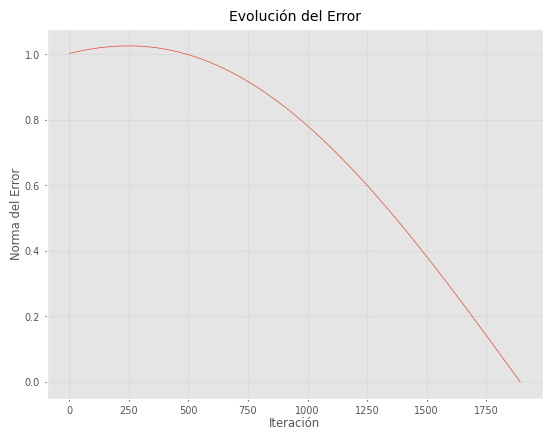

In [ ]:
print("\n" + "="*50)
print("  PRUEBA CON UN ÚNICO Q ALEATORIO")
print("="*50)

# 1. Crear 1 q aleatorio
q_inicial = (np.random.rand(6) - 0.5) * 2 * np.pi
q_inicial = robot.wrap_joints(q_inicial) # Aseguramos que esté dentro de límites, aunque el random ya es amplio

# 2. Calcular su pose y la configuración necesaria
pose_deseada = robot.fkine(q_inicial)
conf_deseada = robot.get_config(q_inicial)
pose_inicial = pose_deseada # La pose inicial para el cálculo es la pose de q_inicial

print(f" Q Inicial (Deseado):\n{q_inicial}")
print(f" Configuración Deseada:\n{conf_deseada}")
print(f" Pose Inicial (Obtenida de Q Inicial):\n{pose_inicial}")

# 3. Pasar por el algoritmo
q_obtenido, status, _, errores = robot.ikine_recta_con_trayectoria_multi(
    pose_deseada, conf=conf_deseada, vd=1, Ts=0.001, max_iter=8000, n_reintentos=20
)

# 4. Calcular la pose obtenida
pose_obtenida = robot.fkine(q_obtenido)

# Imprimir resultados
print("\n" + "-"*50)
print("RESULTADOS DEL ALGORITMO DE CINEMÁTICA INVERSA")
print("-"*50)

if status == 0:
    print("ÉXITO: Cinemática Inversa calculada correctamente.")
elif status == -1:
    print("FALLO: No se alcanzó la tolerancia en el número máximo de iteraciones.")
elif status == -2:
    print("ERROR: Se alcanzó una solución, pero con una configuración distinta.")
else:
    print(f" ESTADO: Código de estado desconocido: {status}.")

print(f"\n Q Inicial (Deseado):\n{q_inicial}")
print(f" Q Obtenido:\n{q_obtenido}")
print(f"\n Pose Inicial:\n{pose_inicial}")
print(f" Pose Obtenida (FKINE de Q Obtenido):\n{pose_obtenida}")
print(f"\n Error final: {errores[-1]:.6e}")

# 5. Imprimir un gráfico de la evolución del error
plt.figure()
plt.plot(errores)
plt.title('Evolución del Error')
plt.xlabel('Iteración')
plt.ylabel('Norma del Error')
plt.grid(True)
plt.show()

print("="*50)
